In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
# !pip install openpyxl
# https://github.com/maryami66/uci_dataset

# https://archive-beta.ics.uci.edu/datasets?Types=Text&Task=Regression&sort=desc&orderBy=NumHits&skip=0&take=10
# 

In [141]:
data.head()
#data['name'] = data['name'].str.lower()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [12]:
tfidf = TfidfVectorizer().fit(data['name'])

In [13]:
tfidf.transform(data['name']).todense()[:5, tfidf.get_feature_names_out() == 'park']

matrix([[0.33346545],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.31731504]])

In [14]:
data = pd.read_csv('data/AB_NYC_2019.csv')

TARGET = ['price']
CATEGORICAL = ['neighbourhood_group', 'neighbourhood', 'room_type']
FEATURES = ['name', 'minimum_nights'] + CATEGORICAL
data['name'] = data['name'].fillna('')
X, y = data[FEATURES], data[TARGET]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [16]:
# https://www.kaggle.com/code/prashantsaraswat88/using-text-based-features-for-price-regression

## Count Vecorizer

In [5]:
#from xgboost import XGBRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer, make_column_selector
from category_encoders import OneHotEncoder

from sklearn.linear_model import LinearRegression

# Count vectorizer
count_vec_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(cols=CATEGORICAL)),
    ('count_vectorizer', ColumnTransformer([
        ('name_cv', CountVectorizer(), 'name')
    ])),
    ('linear_regression', LinearRegression())
])
count_vec_pipeline.fit(X_train, y_train)
y_pred_count_vec = count_vec_pipeline.predict(X_test)
print(mean_squared_error(y_test, y_pred_count_vec))

# # TFIDF
tfidf_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(cols=CATEGORICAL)),
    ('count_vectorizer', ColumnTransformer([
        ('name_tfidf', TfidfVectorizer(), 'name')
    ])),
    ('linear_regression', LinearRegression())
])
tfidf_pipeline.fit(X_train, y_train)
y_pred_tfidf = tfidf_pipeline.predict(X_test)
print(mean_squared_error(y_test, y_pred_tfidf))

NameError: name 'CATEGORICAL' is not defined

In [ ]:
feature_names = tfidf_pipeline[1].get_feature_names_out()
tfidf_features = pd.DataFrame(
    tfidf_pipeline[1].transform(X_test).todense(), 
    columns=feature_names
)
tfidf_features.loc[:, np.random.choice(tfidf_features.columns, 20)]

In [ ]:
feature_names

In [18]:
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

# Topic modelling

In [129]:
# Count vectorizer
tm_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(cols=CATEGORICAL)),
    ('count_vectorizer', ColumnTransformer([
        ('name', make_pipeline(
            CountVectorizer(stop_words='english'), 
            NMF(n_components=10, random_state=7)), 'name')
    ])),
    ('linear_regression', LinearRegression())
])
tm_pipeline.fit(X_train, y_train)
y_pred_count_vec = tm_pipeline.predict(X_test)
print(mean_squared_error(y_test, y_pred_count_vec))

48927.25370776387


## Cross validation

In [27]:
from sklearn.model_selection import cross_val_score

# scores = cross_val_score(tm_pipeline, X_train, y_train, cv=5, scoring=score_fun)

In [38]:
import optuna
from sklearn.model_selection import cross_val_score

def score_fun(est, X, y):
    return mean_squared_error(y, est.predict(X))


def objective(trial):
    n_components = trial.suggest_int('n_components', 10, 100)
    
    tm_pipeline = Pipeline([
        ('one_hot', OneHotEncoder(cols=CATEGORICAL)),
        ('count_vectorizer', ColumnTransformer([
            ('name', make_pipeline(
                CountVectorizer(stop_words='english'), 
                TruncatedSVD(n_components=n_components, random_state=7)), 'name')
        ])),
        ('linear_regression', LinearRegression())
    ])
    
    scores = cross_val_score(tm_pipeline, X_train, y_train, cv=5, scoring=score_fun)
    return np.mean(scores)

study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2023-06-04 20:22:24,213] A new study created in memory with name: no-name-77d72305-e242-4c6e-8929-d5aaf4cd425f
[I 2023-06-04 20:22:33,107] Trial 0 finished with value: 55377.34551481485 and parameters: {'n_components': 82}. Best is trial 0 with value: 55377.34551481485.
[I 2023-06-04 20:22:37,067] Trial 1 finished with value: 56994.17812760598 and parameters: {'n_components': 24}. Best is trial 0 with value: 55377.34551481485.
[I 2023-06-04 20:22:42,105] Trial 2 finished with value: 56064.07085491424 and parameters: {'n_components': 43}. Best is trial 0 with value: 55377.34551481485.
[I 2023-06-04 20:22:45,985] Trial 3 finished with value: 57070.59358829285 and parameters: {'n_components': 22}. Best is trial 0 with value: 55377.34551481485.
[I 2023-06-04 20:22:49,547] Trial 4 finished with value: 57228.08503238663 and parameters: {'n_components': 16}. Best is trial 0 with value: 55377.34551481485.


In [39]:
study.best_params

{'n_components': 82}

In [157]:
cv.fit(X_train['name']).get_feature_names_out()

array(['00', '000', '000sf', ..., 'ﾏﾝﾊｯﾀﾝ', 'ﾏﾝﾊｯﾀﾝ10分',
       'ﾐｯﾄﾞﾀｳﾝｳｴｽﾄｻｲﾄﾞ'], dtype=object)

In [143]:
tm_pipeline[1].transform(X[:5])[[0, 3, 4], :4]

array([[0.        , 0.        , 0.        , 0.10456021],
       [0.        , 0.        , 0.00524839, 0.00821704],
       [0.        , 0.        , 0.00272594, 0.12211661]])

In [130]:
count_vectorizer = tm_pipeline[1].transformers_[0][1][0]
decomposition = tm_pipeline[1].transformers_[0][1][1]

In [131]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title, n_topics=10):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

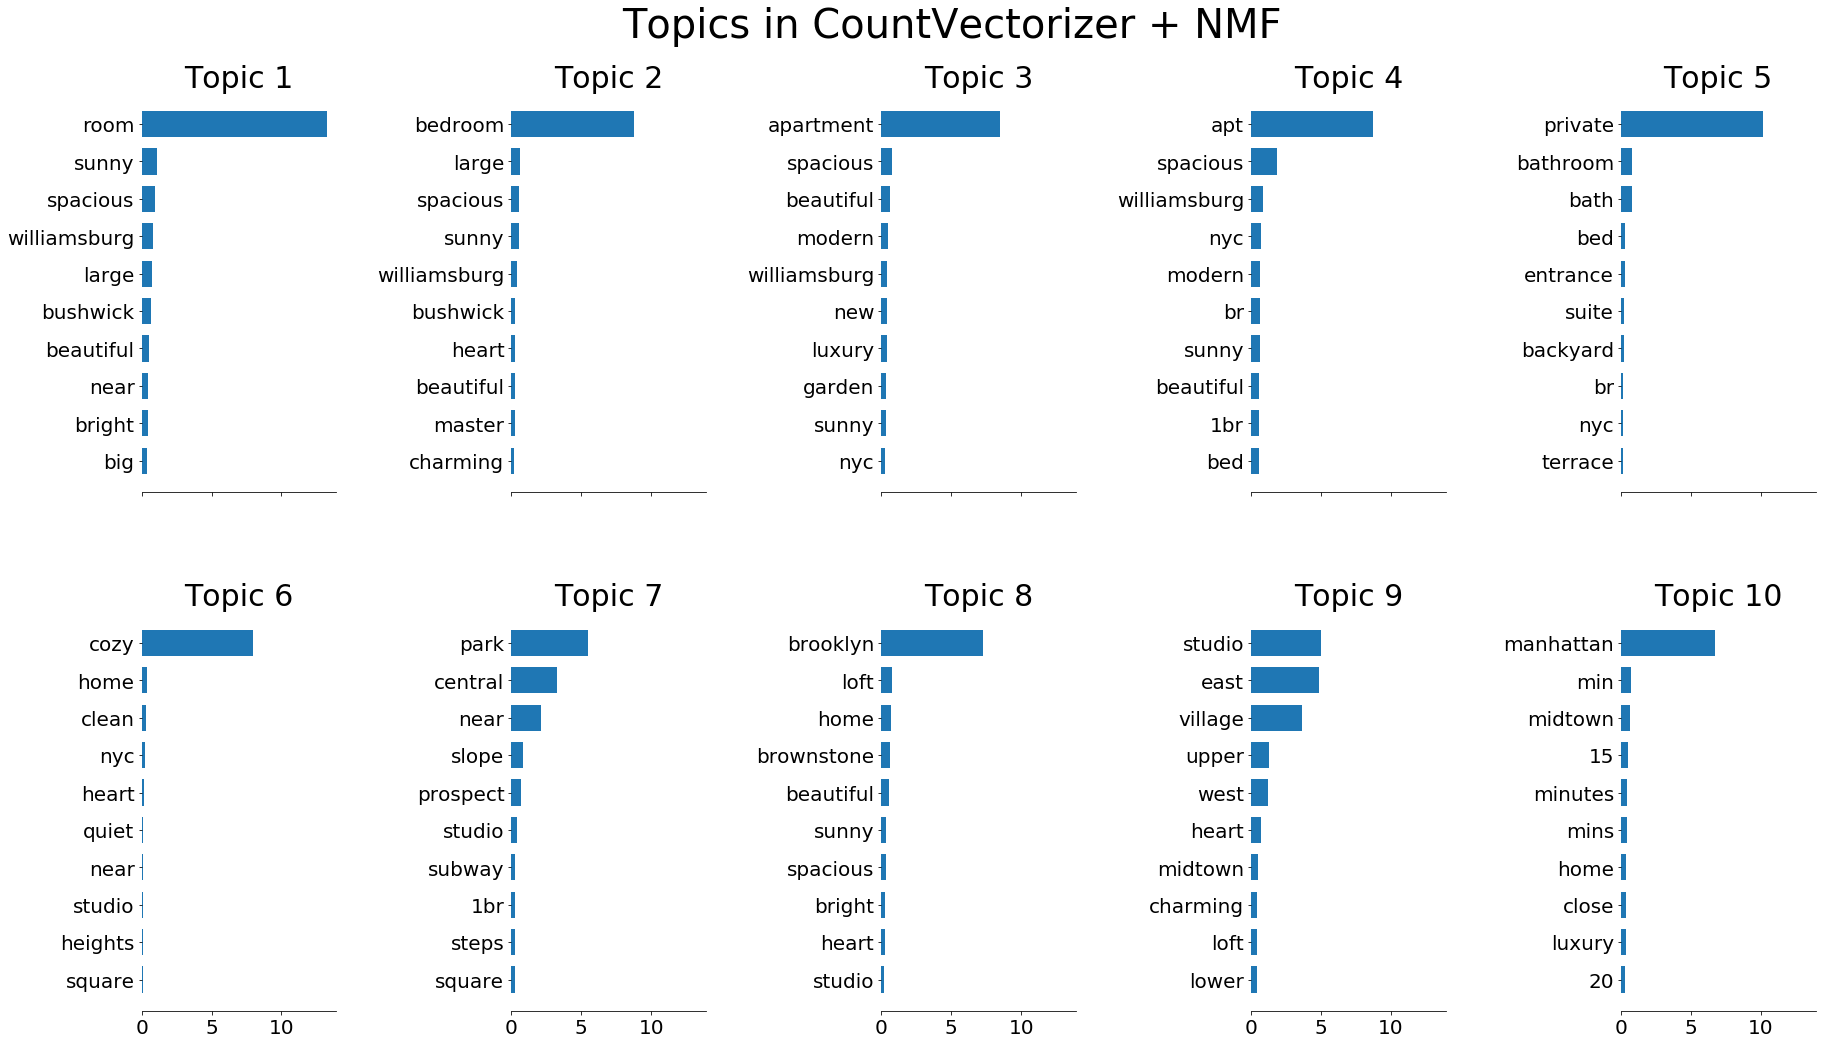

In [132]:
plot_top_words(
    decomposition,
    count_vectorizer.get_feature_names_out(),
    10,
    "Topics in CountVectorizer + NMF",
)

In [133]:
tm_pipeline[1].transform(X).argmax(axis=1)

array([6, 9, 8, ..., 8, 5, 8])

In [134]:
result = tm_pipeline[1].transform(X)

In [135]:
full_encoder  = tm_pipeline[1]
bag_of_words  = full_encoder.transformers_[0][1][0]
decomposition = full_encoder.transformers_[0][1][1]

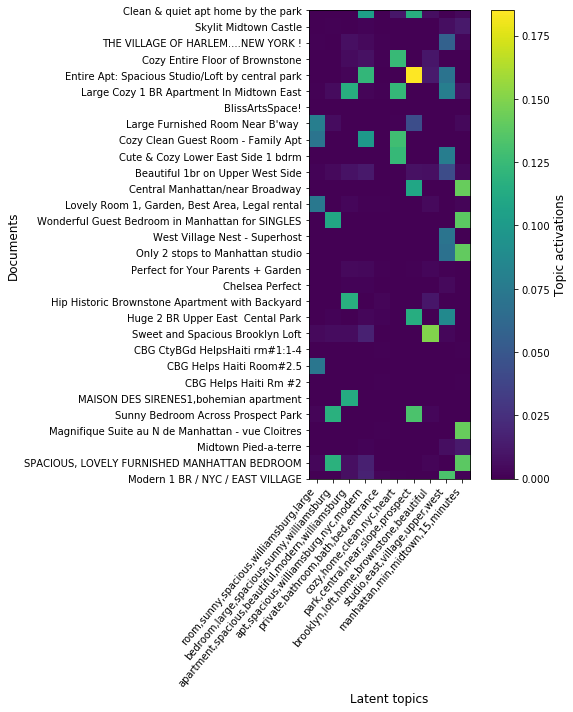

In [136]:
def docs_vs_topics(full_encoder, bag_of_words, decomposition, 
                   n_docs=20, n_top_words=5):
    # Based on https://dirty-cat.github.io/stable/auto_examples/02_investigating_dirty_categories.html#sphx-glr-auto-examples-02-investigating-dirty-categories-py
    
    # Exctracting topic labels
    feature_names = bag_of_words.get_feature_names_out()
    out_features = full_encoder.get_feature_names_out()
    topic_labels = []
    
    for k in range(len(out_features)):
        labels = out_features[k]       
        topic = decomposition.components_[k]
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_labels.append(','.join(top_features))
    
    # Plotting matrix
    encoded_labels = full_encoder.transform(X[:n_docs])
    plt.figure(figsize=(8, len(out_features)))
    plt.imshow(encoded_labels)
    plt.xlabel("Latent topics", size=12)
    plt.xticks(range(0, len(out_features)), labels=topic_labels, rotation=50, ha="right")
    plt.ylabel("Documents", size=12)
    plt.yticks(range(0, n_docs), labels=X['name'][:n_docs].to_numpy().flatten())
    plt.colorbar().set_label(label="Topic activations", size=12)
    plt.tight_layout()
    plt.show()

docs_vs_topics(
    full_encoder  = full_encoder, 
    bag_of_words  = bag_of_words,
    decomposition = decomposition,
    n_docs        = 30
)

In [115]:
decomposition

NMF(n_components=10, random_state=7)

## Hashing

In [151]:
from sklearn.feature_extraction.text import HashingVectorizer

# Count vectorizer
hash_vec_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(cols=CATEGORICAL)),
    ('count_vectorizer', ColumnTransformer([
        ('hash_vec', HashingVectorizer(n_features=1000), 'name')
    ])),
    ('linear_regression', LinearRegression())
])
hash_vec_pipeline.fit(X_train, y_train)
y_pred_count_vec = hash_vec_pipeline.predict(X_test)
print(mean_squared_error(y_test, y_pred_count_vec))

46852.40051616067
